In [1]:
import re
import pickle
import numpy as np
import pandas as pd
# Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Torch ML libraries
import tensorflow as tf
from transformers import AutoTokenizer

# Keras 
from sklearn.model_selection import train_test_split

In [2]:
DATASET_ENCODING = "ISO-8859-1"

In [3]:
train = pd.read_csv('/kaggle/input/kaggle-sa-competition/train.csv',encoding = DATASET_ENCODING)
test = pd.read_csv('/kaggle/input/kaggle-sa-competition/test_features.csv' , encoding = DATASET_ENCODING)

In [4]:
train = train.drop('ID', axis = 1)

In [5]:
train.head()

,Text,Category
0,@JuliaBradbury @SimonCalder @walsop @HodderPRI...,0
1,or here https://t.co/R2tO79Easn â¦ .An in hou...,1
2,@britshmuseum @thehistoryguy Gosh periscope is...,2
3,@Ophiolatrist britishmuseum The stupid #French...,1
4,@SassyClde We won't stop til @britishmuseum du...,1


In [6]:
# removing the User tags and Urls
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"


def preprocess_apply(text):

    text = text.lower()

    # Replace all URls with '<url>'
    text = re.sub(urlPattern,'',text)
    # Replace @USERNAME to '<user>'.
    text = re.sub(userPattern,'', text)
    
    # Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(sequencePattern, seqReplacePattern, text)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    text = re.sub(r'/', ' / ', text)
    return text

In [7]:
train['Text_processed'] = train['Text'].apply(preprocess_apply)

In [8]:
num = 0 
for i , j in train.iterrows():  
    if num == 5: 
        break
    else:
        print('Processed: {}'.format(j['Text_processed']) , j['Category'])
        print('Text: {}'.format(j['Text']), j['Category'])
        num += 1


Processed:   a pleasure to meet you all last week! 0
Text: @JuliaBradbury @SimonCalder @walsop @HodderPRIBA @_TheWhitechapel A pleasure to meet you all last week! 0
Processed: or here  â¦ .an in house solutio proposed to meet flexibility needs. come on  - it's time to talk. 1
Text: or here https://t.co/R2tO79Easn â¦ .An in house solutio proposed to meet flexibility needs. Come on @NationalGallery - it's time to TALK. 1
Processed:   gosh periscope is definitely on trend. high profile people using it and i have not even tried it yet. 2
Text: @britshmuseum @thehistoryguy Gosh periscope is definitely on trend. High profile people using it and I have not even tried it yet. 2
Processed:  britishmuseum the stupid #french prick was crushed by my russian imperial ancestors. ð #waterloo200 1
Text: @Ophiolatrist britishmuseum The stupid #French prick was crushed by my Russian Imperial ancestors. ð #Waterloo200 1
Processed:  we won't stop til  dumps #bp. fill in a feedback form when you're

In [9]:
train['Category'].unique()

array([0, 1, 2, 3])

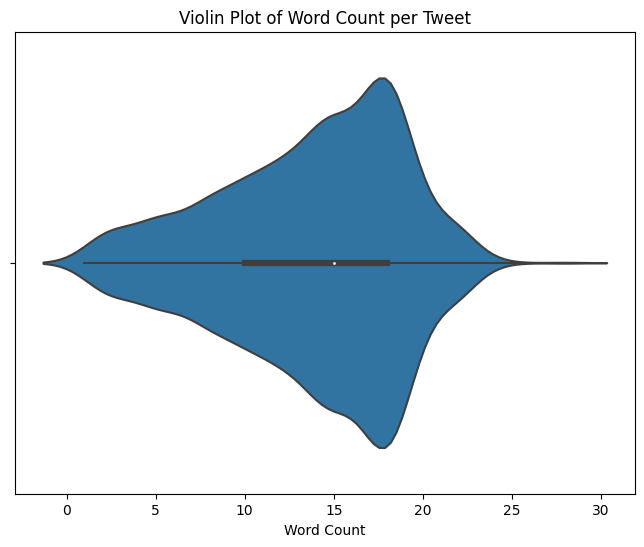

In [10]:
train['word_count'] =train['Text_processed'].apply(lambda x: len(str(x).split()))

# Calculate the statistics
plt.figure(figsize=(8, 6))
sns.violinplot(x=train['word_count'])
plt.title('Violin Plot of Word Count per Tweet')
plt.xlabel('Word Count')
plt.show()

In [11]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
texts = list(train['Text_processed'])
labels = list(train['Category'])

In [13]:
encoded_inputs = tokenizer(
    texts,
    max_length=30,            # Set maximum sequence length to 40 tokens
    padding='max_length',     # Pad sequences to the maximum length
    truncation=True,          # Truncate sequences longer than the maximum length
    return_tensors='np'       # Return NumPy arrays (use 'tf' for TensorFlow tensors directly)
)

In [14]:
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

In [15]:
print("Input IDs:", input_ids[0])
print("Attention Mask:", attention_mask[0])

Input IDs: [ 101  170 4687 1106 2283 1128 1155 1314 1989  106  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Attention Mask: [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
df = pd.DataFrame({
    'input_ids': list(input_ids),
    'attention_mask': list(attention_mask),
    'labels': labels  # Ensure this is a list or array
})

In [17]:
def create_tf_dataset_from_df(df, batch_size=8):
    input_ids = tf.convert_to_tensor(np.array(df['input_ids'].tolist()), dtype=tf.int32)
    attention_mask = tf.convert_to_tensor(np.array(df['attention_mask'].tolist()), dtype=tf.int32)
    labels = tf.convert_to_tensor(np.array(df['labels']), dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        },
        labels
    ))
    dataset = dataset.batch(batch_size)
    return dataset

In [18]:
train_dataset_tf = create_tf_dataset_from_df(df, batch_size=8)

In [19]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=4)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Step 5: Model Training
history = model.fit(
    train_dataset_tf,
    epochs=10,
    validation_data=None
)

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1724580287.325028     121 service.cc:145] XLA service 0x7dbfe067f8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724580287.325083     121 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724580287.325087     121 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724580287.526888     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 68s 62ms/step - loss: 0.5723 - accuracy: 0.8087
Epoch 2/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0410 - accuracy: 0.9937
Epoch 3/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 4/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 5/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 6/10
200/200 [==============================] - 8s 42ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 7/10
200/200 [==============================] - 9s 43ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 8/10
200/200 [==============================] - 9s 43ms/step - loss: 7.9488e-04 - accuracy: 1.0000
Epoch 9/10
200/200 [==============================] - 9s 43ms/step - loss: 6.0413e-04 - accuracy: 1.0000
Epoch 10/10
200/200 [==============================] - 9s 42ms/step - loss: 4.7220e-04 - accu

In [22]:
test.head()

,ID,Text
0,1861,Goodbye @kettlesyard see you in .25 years! htt...
1,354,"@BBC_Culture @PlymouthMuseum Oh dear, why not ..."
2,1334,Fantastic @johnmcdonnellMP standing up for wor...
3,906,"@BBC_Culture @PlymouthMuseum Oh dear, why not ..."
4,1290,@britishmuseum @TripAdvisor it is !


In [25]:
test['Text_processed'] = test['Text'].apply(preprocess_apply)

In [26]:
texts = list(test['Text_processed'])

In [27]:
encoded = tokenizer(
    texts,
    max_length=30,            # Set maximum sequence length to 40 tokens
    padding='max_length',     # Pad sequences to the maximum length
    truncation=True,          # Truncate sequences longer than the maximum length
    return_tensors='np'       # Return NumPy arrays (use 'tf' for TensorFlow tensors directly)
)

In [28]:
test_input_ids = encoded['input_ids']
test_attention_mask = encoded['attention_mask']

In [44]:
test_predictions = model.predict(
    {'input_ids': test_input_ids, 'attention_mask': test_attention_mask}
)

13/13 [==============================] - 1s 39ms/step


In [45]:
test_predictions_labels = np.argmax(test_predictions.logits, axis=1)

In [46]:
output_df = pd.DataFrame({
    'ID': test['ID'],  # Assuming `test` DataFrame has an 'id' column
    'Prediction': test_predictions_labels
})

In [47]:
output_df.to_csv('submission.csv', index=False)

In [48]:
pred = pd.read_csv('/kaggle/working/submission.csv')
pred.head(200)

,ID,Prediction
0,1861,3
1,354,3
2,1334,1
3,906,3
4,1290,0
...,...,...
195,463,1
196,1106,2
197,856,2
198,694,2
